Import libraries, load in datasets

In [ ]:
import pandas as pd

In [ ]:
df=pd.read_csv("combined (1).csv")

In [ ]:
df.shape

(6000, 2)

In [ ]:
from datasets import load_dataset
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    TrainerCallback
)
from google.colab import drive
import os
import json
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
print(df['category'].value_counts())

category
Credit Card                1086
Security & Fraud           1074
Loan Process                868
Online Banking              671
Account Opening             629
Customer Service            451
Rewards & Offers            262
Fees & Charges              240
Interest Rates              208
Branch Experience           194
International Transfers     134
Website Experience           69
App Performance              54
ATM Service                  51
Notifications                 8
Travel                        1
Name: count, dtype: int64


In [ ]:
import pandas as pd

# Original DataFrame: df with column 'category'

# Map all six categories to the new group
category_map_5 = {
    # 1. Digital Banking
    "Online Banking": "Digital Banking",
    "ATM Service": "Digital Banking",
    "Notifications": "Digital Banking",

    # 2. Security & Verification
    "Security & Fraud": "Security & Verification",

    # 3. Accounts & Financial Products
    "Account Opening": "Account Opening",
    "Credit Card": "Credit Card",
    "Loan Process": "Loan Process",

    # 4. Costs, Rates & Rewards
    "Interest Rates": "Costs, Rates & Rewards",
    "Fees & Charges": "Costs, Rates & Rewards",
    "Rewards & Offers": "Costs, Rates & Rewards",

    # 5. Customer Experience & Transactions
    "Customer Service": "Customer Experience",
    "Branch Experience": "Customer Experience",
    "International Transfers": "Customer Experience",
    "Website Experience": "Customer Experience",
    "App Performance": "Customer Experience"
}

df['category'] = df['category'].map(category_map_5)

# Optional: check new distribution
print(df['category'].value_counts())

category
Credit Card                1086
Security & Verification    1074
Customer Experience         902
Loan Process                868
Digital Banking             730
Costs, Rates & Rewards      710
Account Opening             629
Name: count, dtype: int64


category
Account Opening             629
Costs, Rates & Rewards      710
Credit Card                1086
Customer Experience         902
Digital Banking             730
Loan Process                868
Security & Verification    1074
Name: count, dtype: int64


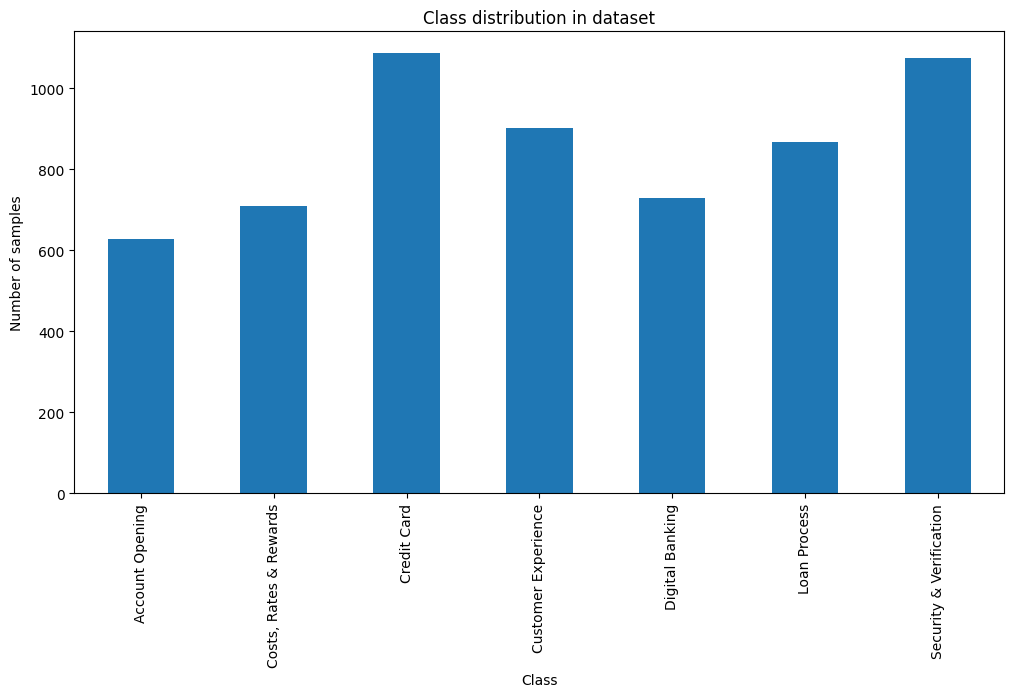

In [ ]:
# Assuming df['label'] has integer class labels
class_counts = df['category'].value_counts().sort_index()
print(class_counts)

# Optional: visualize
import matplotlib.pyplot as plt
class_counts.plot(kind='bar', figsize=(12,6))
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.title("Class distribution in dataset")
plt.show()

In [ ]:
df.isnull().sum()

,0
post,43
category,1


In [ ]:
df= df.dropna()

In [ ]:
df.isnull().sum()

,0
post,0
category,0


In [ ]:
ds = Dataset.from_pandas(df)

In [ ]:
ds = ds.rename_column("post", "text")
ds = ds.rename_column("category", "label")

In [ ]:
ds_split = ds.train_test_split(test_size=0.3, seed=676769, shuffle = True)
train_ds = ds_split["train"]
val_ds = ds_split["test"]

In [ ]:
train_ds.shape

(4169, 3)

In [ ]:
val_ds.shape

(1787, 3)

In [ ]:
import warnings

# Ignore specific PyTorch DataLoader warning
warnings.filterwarnings(
    "ignore",
    message=r"'pin_memory' argument is set as true but no accelerator is found.*"
)

Label encoding

In [ ]:
labels = list(set(ds["label"]))
label2id = {l:i for i,l in enumerate(labels)}
id2label = {i:l for l,i in label2id.items()}

def encode_label(example):
    example["label"] = label2id[example["label"]]
    return example

train_ds = train_ds.map(encode_label)
val_ds   = val_ds.map(encode_label)


Map:   0%|          | 0/4169 [00:00<?, ? examples/s]

Map:   0%|          | 0/1787 [00:00<?, ? examples/s]

In [ ]:
print(label2id)
print(id2label)

{'Credit Card': 0, 'Security & Verification': 1, 'Loan Process': 2, 'Costs, Rates & Rewards': 3, 'Account Opening': 4, 'Digital Banking': 5, 'Customer Experience': 6}
{0: 'Credit Card', 1: 'Security & Verification', 2: 'Loan Process', 3: 'Costs, Rates & Rewards', 4: 'Account Opening', 5: 'Digital Banking', 6: 'Customer Experience'}


Mount Google Drive

In [ ]:
drive.mount('/content/drive/')

save_dir = '/content/drive/MyDrive/distilroberta_reddit_classifier_4'
os.makedirs(save_dir, exist_ok=True)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Load tokenizer + model

In [ ]:
model_name = "distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Perform Tokenization

In [ ]:
lengths = df["post"].astype(str).apply(lambda x: len(tokenizer.tokenize(x)))
print(lengths.describe())
print(lengths.quantile(0.90))
print(lengths.quantile(0.95))

Token indices sequence length is longer than the specified maximum sequence length for this model (1028 > 512). Running this sequence through the model will result in indexing errors


count    5956.000000
mean      202.490094
std       234.878255
min         1.000000
25%        63.000000
50%       138.000000
75%       262.000000
max      5779.000000
Name: post, dtype: float64
437.0
606.0


In [ ]:
def tokenize_function(examples):
    texts = [str(t) if t is not None else "" for t in examples["text"]]
    return tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=256
    )

train_ds = train_ds.map(tokenize_function, batched=True)
val_ds   = val_ds.map(tokenize_function, batched=True)

Map:   0%|          | 0/4169 [00:00<?, ? examples/s]

Map:   0%|          | 0/1787 [00:00<?, ? examples/s]

Set up loss logging callback

In [ ]:
class LossLoggingCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.steps = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if 'loss' in logs and state.global_step % 20 == 0:
                self.train_losses.append(logs['loss'])
                self.steps.append(state.global_step)

            if 'eval_loss' in logs:
                self.val_losses.append(logs['eval_loss'])

    def save_losses(self, filepath):
        data = {
            "steps": self.steps,
            "train_losses": self.train_losses,
            "val_losses": self.val_losses
        }
        with open(filepath, "w") as f:
            json.dump(data, f)

loss_callback = LossLoggingCallback()

Set up metric compution method (F1 & Accuracy)

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }

Training arguments

In [ ]:
training_args = TrainingArguments(
    output_dir=save_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=500,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=3,
    report_to="none"
)

Set up trainer

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    callbacks=[loss_callback],
    compute_metrics=compute_metrics
)

/tmp/ipython-input-171709677.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Train + save model & losses + display metrics

In [ ]:
import torch
print(torch.cuda.is_available())

True


In [ ]:
trainer.train()

trainer.save_model(f"{save_dir}/model_trained_on_labeled_reddit")
loss_callback.save_losses(f"{save_dir}/loss_history_new_model.json")

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,1.106409,0.595971,0.572587
2,1.169100,1.038214,0.632904,0.623939


In [ ]:
train_metrics = trainer.evaluate(train_ds)
print("Train:", train_metrics)

val_metrics = trainer.evaluate(val_ds)
print("Val:", val_metrics)

Train: {'eval_loss': 0.9628974795341492, 'eval_accuracy': 0.6904761904761905, 'eval_f1': 0.6754786933197862, 'eval_runtime': 27.6862, 'eval_samples_per_second': 151.7, 'eval_steps_per_second': 9.499, 'epoch': 2.0}
Val: {'eval_loss': 1.111642837524414, 'eval_accuracy': 0.6255555555555555, 'eval_f1': 0.6109821536385268, 'eval_runtime': 11.5573, 'eval_samples_per_second': 155.746, 'eval_steps_per_second': 9.777, 'epoch': 2.0}


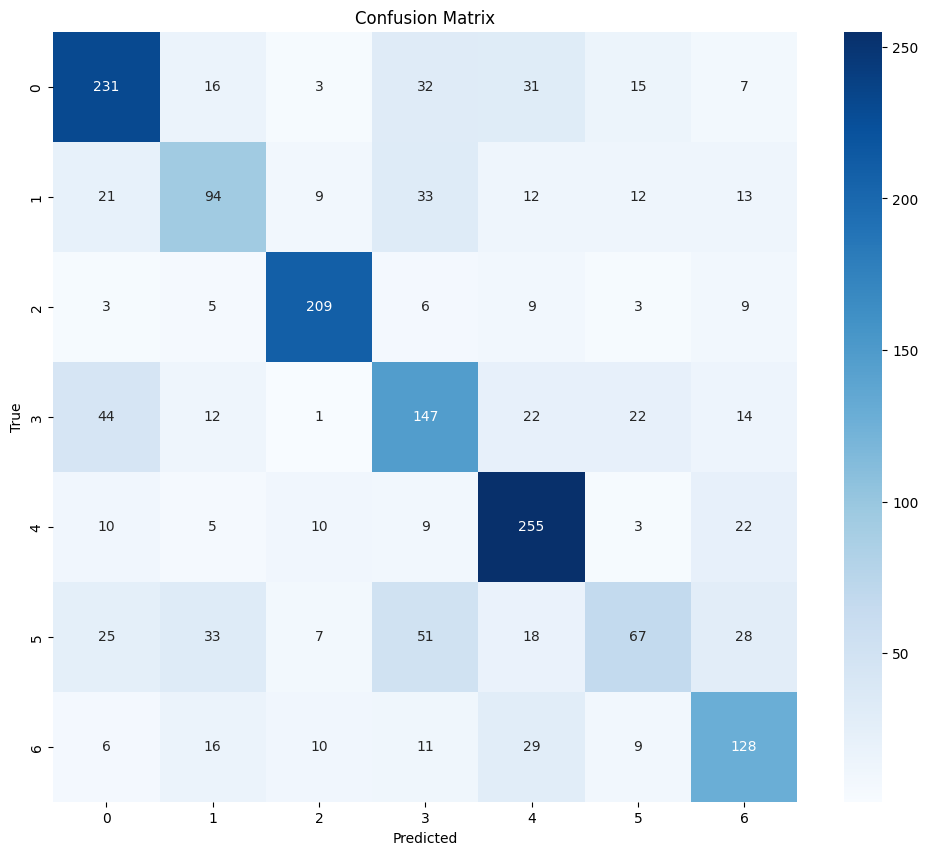

              precision    recall  f1-score   support

           0     0.6794    0.6896    0.6844       335
           1     0.5193    0.4845    0.5013       194
           2     0.8394    0.8566    0.8479       244
           3     0.5087    0.5611    0.5336       262
           4     0.6782    0.8121    0.7391       314
           5     0.5115    0.2926    0.3722       229
           6     0.5792    0.6124    0.5953       209

    accuracy                         0.6329      1787
   macro avg     0.6165    0.6155    0.6106      1787
weighted avg     0.6254    0.6329    0.6239      1787



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions on the validation set
predictions = trainer.predict(val_ds)  # returns a PredictionOutput object

# Convert logits to class indices
preds = predictions.predictions.argmax(axis=1)
labels = predictions.label_ids

# Confusion matrix
cm = confusion_matrix(labels, preds)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Detailed class-wise metrics
print(classification_report(labels, preds, digits=4))

testing on real world reddit data

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import pandas as pd
from datasets import Dataset

In [ ]:
combined_df = pd.read_csv("combined.csv")
ds = Dataset.from_pandas(combined_df)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model_path = "/content/drive/MyDrive/model_trained_on_labeled_reddit"

tokenizer = AutoTokenizer.from_pretrained(model_path, local_files_only=True)
model = AutoModelForSequenceClassification.from_pretrained(
    model_path,
    local_files_only=True
)

In [ ]:
tester = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,        # can be None if you only want to evaluate
    eval_dataset=val_ds,           # or your df wrapped as a Dataset
    tokenizer=tokenizer,
    callbacks=[loss_callback],     # optional
    compute_metrics=compute_metrics
)

/tmp/ipython-input-152547453.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  tester = Trainer(


In [ ]:
results = tester.evaluate(eval_dataset=val_ds)
print(results)

{'eval_loss': 4.542267322540283, 'eval_model_preparation_time': 0.0026, 'eval_accuracy': 0.21666666666666667, 'eval_f1': 0.21666666666666667, 'eval_runtime': 175.6645, 'eval_samples_per_second': 3.416, 'eval_steps_per_second': 0.216}
